
This notebook runs the text summerizer on CNN/Daily mail dataset using Gated Recurrent Units architecture in Recurrent Neural Networks. Dataset size : 5000

Installing necessary librabries.

We have downgraded Keras and Tensorflow as were facing an issue during inference phase.

In [ ]:
# !pip install q keras==2.2.4
# !pip install q tensorflow==1.15.2
# !pip install q numpy==1.19.5
# !pip install tensorflow-gpu==1.15.2  # GPU
# !pip install contractions

In [ ]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
from pathlib import Path
from io import StringIO
import string  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import contractions
from nltk.corpus import wordnet
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import keras
import tensorflow
# import tensorflow-gpu
print(keras.__version__)
print(tensorflow.__version__)
# print(tensorflow-gpu.__version__)

2.2.4
1.15.2


Using TensorFlow backend.


In [ ]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import LSTM,Input, GRU, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
# from keras import Input

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We are accessing our datasets using Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Function to Load and read the dataset.

In [ ]:
def load_dataset():
  zf = ZipFile('/content/drive/MyDrive/AMLProjectDataset.zip')
  t_df = pd.read_csv(zf.open('cnn_dailymail/train.csv'))
  v_df=pd.read_csv(zf.open('cnn_dailymail/validation.csv'))
  test_df=v_df=pd.read_csv(zf.open('cnn_dailymail/test.csv'))
  
  return t_df,v_df,test_df

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    # tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


### Preprocessing Functions: <br>
1) Lemmatizing <br>
2) Removing Punctuations <br>
3) Removing stopwords <br>
4) Removing words less than length 3 <br>

In [ ]:
def preprocessing(data,data_column):
  train_df = data.drop(['id'], axis=1)
  processed_sent=[]
  for sent in train_df[data_column]:
    processed_sent_sub=re.sub("[\(\[].*?[\)\]]", "", sent)
    processed_sent_sub=contractions.fix(processed_sent_sub)
    processed_sent.append(processed_sent_sub)
  WORD = re.compile(r'\w+')
  sentence = []
  for art in processed_sent:
    words = WORD.findall(art)
    # print(words)
    sentence.append(words)
  eng_stopwords = stopwords.words('english')
  punctuation = string.punctuation
  format_sent = []

  for sntc in sentence:
    format_words = []
    for word in sntc:
      if word not in eng_stopwords and word not in punctuation and len(word)>2:
        format_words.append(word.lower())
    format_words = nltk.pos_tag(format_words)
    doc = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1][0].upper())) for word in format_words]
    format_sent.append(" ".join(doc))

  return format_sent

### Function to add start and end tokens: 

In [ ]:
def add_start_end_token(data):
  #data= data.apply(lambda x : 'sostok '+ x + ' eostok')
  data_sos_eos=[]
  for x in data:
    data_sos_eos.append('sos '+x+' eos')

  return data_sos_eos

### Functions for tokenizing and padding:

In [ ]:
def tokenizer(data):
    tokenizer = Tokenizer(oov_token = "<UNK>")
    #print(tokenizer.num_words)
    tokenizer.fit_on_texts(data)
    
    #print(data[0])
    return tokenizer

def token_fit(data,tokenizer):
    sequences=tokenizer.texts_to_sequences(data)
    word_index=tokenizer.word_index
    print(len(max(sequences,key=len)))
    return sequences,len(max(sequences,key=len)),len(word_index)

def padding(sequences,global_max_len):
    padded = pad_sequences(sequences, padding = "post",maxlen=global_max_len)
    return padded,len(padded[0])

### Model Definition:

In [ ]:
# Defining hyperparameters
latent_dim = 256
embedding_dim = 256

In [ ]:
#create model with encoder decoder architecture:

class MySeq2Seq:

  def __init__(self, latent_dim,embedding_dim,ARTICLE_LEN,ART_VOCAB_SIZE,HIGHLIGHT_LEN, HIGH_VOCAB_SIZE):
    with tensorflow.device("/gpu:0"):
      self.encoder_inputs = Input(shape=(ARTICLE_LEN,))
      self.enc_emb_layer =  Embedding(HIGH_VOCAB_SIZE, embedding_dim,trainable=True)

      self.encoder_gru1 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
      self.encoder_gru2 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
      self.encoder_gru3= GRU(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)

      self.decoder_inputs = Input(shape=(None,))
      self.dec_emb_layer = Embedding(HIGH_VOCAB_SIZE, embedding_dim,trainable=True) 
      self.decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
      self.decoder_dense =  TimeDistributed(Dense(HIGH_VOCAB_SIZE, activation='softmax'))
  
  def create(self):
    with tensorflow.device("/gpu:0"):
      enc_emb = self.enc_emb_layer(self.encoder_inputs)
      encoder_output1, state_c1 = self.encoder_gru1(enc_emb)
      encoder_output2, state_c2 = self.encoder_gru2(encoder_output1)
      encoder_outputs, state_c= self.encoder_gru3(encoder_output2)

      self.encoder_outputs = encoder_outputs
      self.state_c = state_c

      dec_emb = self.dec_emb_layer(self.decoder_inputs)
      decoder_outputs, decoder_state = self.decoder_gru(dec_emb,initial_state=[state_c])

      self.decoder_outputs = self.decoder_dense(decoder_outputs)

      self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)
      self.model.summary()


      #inference

      #encoder - testing
      self.encoder_testing = Model(inputs=self.encoder_inputs, outputs =[self.encoder_outputs,self.state_c])
      self.encoder_testing.summary()

      #decoder - testing
      self.decoder_state_input = Input(shape=(latent_dim,))
      self.decoder_hidden_state_input = Input(shape=(ARTICLE_LEN,latent_dim))

      dec_emb2 = self.dec_emb_layer(self.decoder_inputs)

      self.decoder_outputs, self.state_c = self.decoder_gru(dec_emb2, initial_state=self.decoder_state_input )

      self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

      print("self.decoder_inputs",self.decoder_inputs.get_shape())
      print("self.decoder_state_input",self.decoder_state_input.get_shape())
      # print("self.decoder_hidden_state_input",self.decoder_hidden_state_input.get_shape())

      print("self.decoder_outputs",self.decoder_outputs.get_shape())
      print("self.state_c",self.state_c.get_shape())

      self.decoder_testing = Model([self.decoder_inputs]+[self.decoder_hidden_state_input,self.decoder_state_input], [self.decoder_outputs]+[self.state_c])
      self.decoder_testing.summary()



In [ ]:
train_data,validation_data,test_data=load_dataset()

In [ ]:
data_size=5000

In [ ]:
format_data=preprocessing(train_data[0:data_size],'article')
format_highlight=preprocessing(train_data[0:data_size],'highlights')
format_val_data = preprocessing(validation_data[0:data_size],'article')
format_val_highlight = preprocessing(validation_data[0:data_size],'highlights')
format_test_data = preprocessing(test_data[0:data_size],'article')
format_test_highlight = preprocessing(test_data[0:data_size],'highlights')

We have capped the length of the text and summary according to the below histograms of word counts.

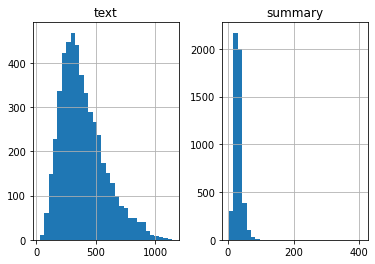

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in format_data:
      text_word_count.append(len(i.split()))

for i in format_highlight:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max_text_len=1000
max_summary_len=100

In [ ]:
short_text=[]
short_summary=[]
short_val_summary=[]
short_val_text=[]
short_test_summary=[]
short_test_text=[]
for i in range(len(format_data)):
    if(len(format_highlight[i].split())<=max_summary_len and len(format_data[i].split())<=max_text_len):
        short_summary.append(format_highlight[i])
        short_text.append(format_data[i])


for i in range(len(format_val_data)):
    if(len(format_val_highlight[i].split())<=max_summary_len and len(format_val_data[i].split())<=max_text_len):
        short_val_summary.append(format_val_highlight[i])
        short_val_text.append(format_val_data[i])

for i in range(len(format_test_data)):
    if(len(format_test_highlight[i].split())<=max_summary_len and len(format_test_data[i].split())<=max_text_len):
        short_test_summary.append(format_test_highlight[i])
        short_test_text.append(format_test_data[i])
        
format_highlight=short_summary
format_data=short_text

format_val_highlight=short_val_summary
format_val_data=short_val_text

format_test_highlight=short_test_summary
format_test_data=short_test_text

In [ ]:
len(max(format_data,key=len))

7014

In [ ]:
format_data[0]

'associated press publish est october 2013 updated est october 2013 the bishop fargo catholic diocese north dakota expose potentially hundred church member fargo grand fork jamestown hepatitis virus late september early october the state health department issue advisory exposure anyone attend five church take communion bishop john folda fargo catholic diocese north dakota expose potentially hundred church member fargo grand fork jamestown hepatitis state immunization program manager molly howell say risk low official feel important alert people possible exposure the diocese announce monday bishop john folda take time diagnose hepatitis the diocese say contract infection contaminate food attend conference newly ordain bishop italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota bishop locate'

### Text Tokenizing and Padding:

In [ ]:
#padded_seq,ART_VOCAB_SIZE,ARTICLE_LEN=tokenizer(format_data)
X_token=tokenizer(format_data)
sos_eos_highlight=add_start_end_token(format_highlight)
Y_token=tokenizer(sos_eos_highlight)

seq,max_len_data,ART_VOCAB_SIZE=token_fit(format_data,X_token)
seq_highlight,max_len_data_highlights,HIGH_VOCAB_SIZE=token_fit(sos_eos_highlight,Y_token)

#padded_val_seq_data, VAL_ART_VOCAB_SIZE, VAL_ART_LEN = tokenizer(format_val_data)
val_seq_data, max_len_val_data, VAL_ART_VOCAB_SIZE= token_fit(format_val_data,X_token)
sos_eos_val_highlight=add_start_end_token(format_val_highlight)
#padded_val_seq_highlight, VAL_HIGH_VOCAB_SIZE, VAL_HIGHLIGHT_LEN = tokenizer(sos_eos_val_highlight)
val_seq_highlight,max_len_val_data_highlights, VAL_HIGH_VOCAB_SIZE= token_fit(sos_eos_val_highlight,Y_token)

#padded_test_seq_data, TEST_ART_VOCAB_SIZE, TEST_ART_LEN = tokenizer(format_test_data)
test_seq_data, max_len_test_data, TEST_ART_VOCAB_SIZE= token_fit(format_test_data,X_token)
sos_eos_test_highlight=add_start_end_token(format_test_highlight)
#padded_test_seq_highlight, TEST_HIGH_VOCAB_SIZE, TEST_HIGHLIGHT_LEN = tokenizer(sos_eos_test_highlight)
test_seq_highlight, max_len_test_data_highlights, TEST_HIGH_VOCAB_SIZE= token_fit(sos_eos_test_highlight,Y_token)

global_max_len_data=max([max_len_data,max_len_val_data,max_len_test_data])
global_max_len_data_highlights=max([max_len_data_highlights,max_len_val_data_highlights,max_len_test_data_highlights])

padded_seq,ARTICLE_LEN=padding(seq,global_max_len_data)
padded_val_seq_data, VAL_ART_LEN = padding(val_seq_data,global_max_len_data)
padded_test_seq_data, TEST_ART_LEN = padding(test_seq_data,global_max_len_data)

padded_seq_highlight,HIGHLIGHT_LEN=padding(seq_highlight,global_max_len_data_highlights)
padded_val_seq_highlight, VAL_HIGHLIGHT_LEN = padding(val_seq_highlight,global_max_len_data_highlights)
padded_test_seq_highlight, TEST_HIGHLIGHT_LEN = padding(test_seq_highlight,global_max_len_data_highlights)
#print(words)

1000
98
997
98
997
98


In [ ]:
global_max_highlight_vocab_size = max(HIGH_VOCAB_SIZE,VAL_HIGH_VOCAB_SIZE,TEST_HIGH_VOCAB_SIZE)

global_max_article_vocab_size = max(ART_VOCAB_SIZE,VAL_ART_VOCAB_SIZE,TEST_ART_VOCAB_SIZE)

In [ ]:
K.clear_session()  #Resets all state generated by Keras

### Creating model

In [ ]:
with tensorflow.device("/gpu:0"):
  seq2seq = MySeq2Seq(latent_dim,embedding_dim,global_max_len_data,global_max_article_vocab_size+1,global_max_len_data_highlights, global_max_highlight_vocab_size+1)

  seq2seq.create()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 256)    5063424     input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 1000, 256),  393984      embedding[0][0]                  
_____________________________________________________________________________________________

In [ ]:
from tensorflow.keras import callbacks
class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\n Epoch {} ended".format(epoch))
        #print(seq2seq.model.layers[1].get_weights())

### Creating model

In [ ]:
#Adding Metrics
with tensorflow.device("/gpu:0"):
  seq2seq.model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
#Adding Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

### Training and validating model

In [ ]:
with tensorflow.device("/gpu:0"):
  history = seq2seq.model.fit([padded_seq,padded_seq_highlight[:,:-1]], padded_seq_highlight.reshape(padded_seq_highlight.shape[0],padded_seq_highlight.shape[1], 1)[:,1:] ,epochs=50,callbacks=[CustomCallback()],batch_size= 64, validation_data=([padded_val_seq_data,padded_val_seq_highlight[:,:-1]], padded_val_seq_highlight.reshape(padded_val_seq_highlight.shape[0],padded_val_seq_highlight.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4975 samples, validate on 4972 samples
Epoch 1/50
4928/4975 [============================>.] - ETA: 2s - loss: 3.4670 - acc: 0.6640
 Epoch 0 ended
4975/4975 [==============================] - 316s 64ms/sample - loss: 3.4566 - acc: 0.6646 - val_loss: 2.9579 - val_acc: 0.6550
Epoch 2/50
4928/4975 [============================>.] - ETA: 2s - loss: 2.7656 - acc: 0.6819
 Epoch 1 ended
4975/4975 [==============================] - 313s 63ms/sample - loss: 2.7649 - acc: 0.6819 - val_loss: 2.9155 - val_acc: 0.6662
Epoch 3/50
4928/4975 [============================>.] - ETA: 2s - loss: 2.6884 - acc: 0.6855
 Epoch 2 ended
4975/4975 [==============================] - 312s 63ms/sample - loss: 2.6906 - acc: 0.6853 - val_loss: 2.9125 - val_acc: 0.6674
Epoch 4/50
4928/4975 [============================>.] - ETA: 2s - loss: 2.6555 - acc: 0.6865
 Epoch 3 ended
4975/4975 [==============================]

### Visualization of training and validation accuracy and loss

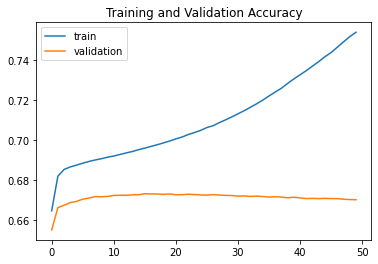

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='validation') 
pyplot.title("Training and Validation Accuracy")
pyplot.legend() 
pyplot.show()

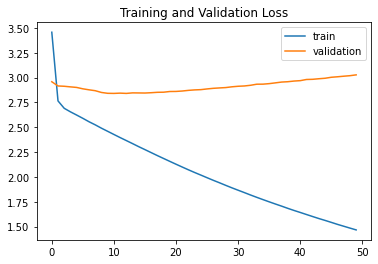

In [ ]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='validation') 
pyplot.title("Training and Validation Loss")
pyplot.legend() 
pyplot.show()

### Inference phase

In [ ]:
def infer_results(padded_test_seq_data):
  All_sentences = []
  for i in range(len(padded_test_seq_data)):
    # the input sequence to the encoder is the text data
    inputseq = padded_test_seq_data[i].reshape(1,global_max_len_data)
    encoder_op,encoder_c=seq2seq.encoder_testing.predict(inputseq)
    infered_op = np.zeros((1,1))


    # start token is sent to the decoder to infer outputs.
    infered_op[0,0] = 2
    decoded_sent=[]
    reverse_words = Y_token.index_word
    # print("Reverse", reverse_words)
    while True:
      decoder_op,decoder_c=seq2seq.decoder_testing.predict([infered_op]+[encoder_op,encoder_c])
      token_index=np.argmax(decoder_op[0,-1,:])
      # print(token_index)
      token=reverse_words[token_index]

      if token=="<UNK>" or token=="eos" or len(decoded_sent)>=global_max_len_data_highlights:
        #break the loop if unknown or end of sequence token is reached
        break

      if token!="<UNK>" or token!="eos":
        decoded_sent.append(token)

      infered_op[0,0]  = token_index

      encoder_c=decoder_c

    sent = " ".join(decoded_sent)
    All_sentences.append(sent)
  return All_sentences
All_sentences = infer_results(padded_test_seq_data)

### Rouge Metric:

We have used Rouge score to compare the predicted summary and the actual summary to find the Precision, Recall and F1 scores.

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [ ]:
presicion = []
recall = []
f1 = []
print(len(All_sentences))
for (h, r) in zip(All_sentences, format_test_highlight):
    if h != "" and r != "":
      score = rouge.get_scores(h, r)
      # print(score)
      s = score[0]['rouge-1']
      presicion.append(s["p"])
      recall.append(s["r"])
      f1.append(s["f"])

print("Presicion:",sum(presicion)/len(presicion))
print("Recall:", sum(recall)/len(recall))
print("F1:",sum(f1)/len(f1))

4972
Presicion: 0.07939903264902061
Recall: 0.060089764269303146
F1: 0.06546251745375209


### Inferred results visualization

Following cells show some good examples of text summerization as well as some failed examples on Amazon dataset.

##### Some examples:

In [ ]:
index = 100
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   mother two lose ten stone become concerned size cause look like man kim callaghan pile pound birth two child reach worry 20st 3lb however determine slim shrunk slender 9st 10lb take exercise swap starchy meal small portion kim callaghan become worried weight cause look like man go dramatic diet saw lose half body weight kim weight loss saw drop incredible ten dress size slim slinky size eight before slimmed kim wardrobe limit size figure hide garment afraid lose femininity kim live ardee county louth ireland say turn masculine clothing way hide shape wear baggy trouser flappy shirt fat try cover body embarrass stop look like woman now slimmed feel confident enough wear dress feel healthy feminine kim marry husband sean callaghan 1999 after pair get married splash double deep fat fryer kim pile pound give birth two child become heavier worried husband sean would see sexy woman marry before weight loss kim limit wardrobe size clothing slinky size the housewife diet consist mai

In [ ]:
index = 2682
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   renowned fashion designer collette dinnigan place luxurious paddington home market splash stylish waterfront home one sydney exclusive suburbs the four bedroom 19th century sandstone property cost dinnigan million back 2009 set hammer may after purchase lavish million watson bay property last month husband bradley cock dinnigan hop cool million lavishly renovated paddington house sell scroll video fashion queen collette dinnigan put four bedroom 19th century sandstone property market the two storey terrace home built 1880 set 379 square metre prime paddington real estate one oldest house paddington renovation stun say sell agent ben collier msgrath estate agent sell property along will man ballard property the international designer husband carefully renovate property sympathetic keep period style still keep contemporary say collier collier say owner love combination house proximity restaurant cafes along unusually large terrace make property actual house most terrace area a

In [ ]:
index = 4411
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   jack wilshere may rub shoulder like alexis sanchez mesut ozil daily basis leave starstruck thursday even meet brazil legend pele even well wilshere arsenal midfielder give opportunity interview three time world cup winner launch party 10ten talent both wilshere pele along glenn hoddle client england international make sure fan twitter know meet post several tweet brazil legend pele arsenal midfielder jack wilshere pose photo launch 10ten talent wilshere give honour interview legendary pele ask twitter question fan earlier thursday wilshere tweet look forward meet pele tonight ask best question send jackmeetspele the year old follow several tweet event many include photo pele meanwhile pele acknowledge last year world cup disaster brazil surprise quickly likes oscar ramires bounce back barclays premier league season brazil humiliate germany semi final defeat host thrash holland third place play pele score goal game brazil world cup three time former santos striker still find 

In [ ]:
index = 21
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   wanted police fit image millionaire people trafficker ermias ghermay think make 72m accomplice mered medhanie smuggling migrant last two year two millionaire people trafficker hear mock migrant boat disaster result thousand deaths mediterranean report one eritrean call mered medhanie also know the general heard laugh police wiretap overload migrant ship problem cause capsize medhanie base libyan capital tripoli say boast they say put many aboard one want leave hurry second trafficker ermias ghermay think make 72million medhanie smuggle last two year also show callous disregard plight customer hear declare last summer they organise another trip day ago know happen probably die ghermay also live tripoli already wanted arrest warrant connection october 2013 capsize lampedusa leave 366 dead report conversation come day least 900 people fear drowned one bad maritime disaster since end world war two more 700 perish last week alone italian police yesterday release ghermay photofit 

In [ ]:
index = 87
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   water police call help search miss autistic boy year old luke shambrook fascinate water swim luke miss two night victorian national park temperature drop low eight degree celsius saturday night however may even know lose know frequently hide accord family last see leave candlebark campground fraser national park near lake eildon 30am good friday accord herald sun year old reportedly see walk near devil river sunday four kilometre south campsite last see search crew rush location police remain comfortable young boy still alive luke limit speech family say probably confuse may even aware lose camper help rescue team include air wing dog squad local police ses volunteer search thick bushland scroll video luke shambrook last see national park 30am good friday understood wander see since police assume luke spent hour without food water saturday night would experience temperature low degree celsius police hold hope luke able stay reasonably warm last see wear beanie warm jacket th

In [ ]:
index = 985
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   juventus rule move manchester unite loan star radamel falcao claim colombia striker wag beyond mean falcao endure difficult period old trafford arrive expensive loan deal monaco last summer the year old unlikely remain club score four goal fail force way louis van gaal start juventus general manager beppe marotta claim falcao want come turin last summer serie champion take race sign radamel falcao score four goal since arrive manchester unite monaco the colombian expect leave summer although juventus claim cannot afford falcao monaco player loan manchester unite wage substantial beyond mean marotta tell gazzetta dello sport utopian imagine juventus shirt however marotta claim italian reach champion league semi final expense monaco wednesday interested strike pair paulo dybala edinson cavani with former manchester city striker carlos tevez set return boca junior end season juventus need reinforce forward line palermo dybala edinson paris saint germain top wishlist the serie c

In [ ]:
index = 1597
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   this shocking moment labour candidate collapse second due take part live debate darren jones stand bristol north west see step away podium complain pin needle legs the labour candidate start sway foot front worry audience member collapse front presenter ellie pitt opponent make bristol programme decision make darren jones see step away podium front worry look opponent second programme due air the year old approach presenter ellie pitt take glass collapse front studio audience second due air the channel force cut commercial year old recover studio floor ambulance call cancel programme delayed nine minute once back foot jones escort build leave local candidate ukip michael frost liberal democrat clare campion smith conservative charlotte leslie take part debate without later say feeling well faint determine cancel event blame collapse cold brought campaign say team work really hard make sure return labour bristol north west fight thing really matter manage catch cold process w